# **Orienatation Estimation with Quadrature Filters**

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from test_image import get_test_image

### Obtain Bank of Quadrature Filters

In [46]:
ksize=(9,9)   # kernel size
sigma=1.0     # std deviation of Gaussian envelope (controls bandwidth)
# theta=0.0     # orientation
lambd=5.0     # wavelength
gamma=0.125   # spatial aspect ratio
psi=0         # phase offset


# get bank of steered quadrature filters
orientations = np.radians(np.array([0, -60, -120]))

even_filters = []
odd_filters = []

for theta in orientations:
    even_filters.append(cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F))
    odd_filters.append(cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi + np.pi/2, ktype=cv2.CV_64F))

### TEMP: Bonus Exploration

In [158]:
even = even_filters[0]
odd = odd_filters[0]

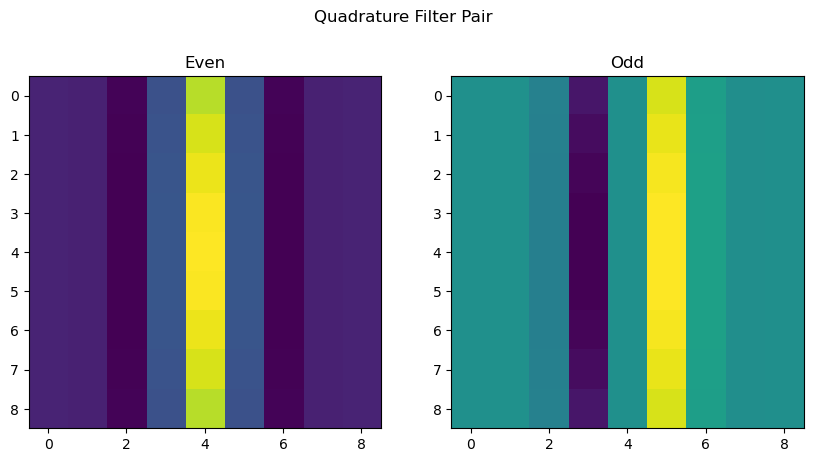

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Quadrature Filter Pair")
ax[0].imshow(even)
ax[0].set_title("Even")
ax[1].imshow(odd)
ax[1].set_title("Odd"); 

In [185]:
test_image = get_test_image(512).astype(np.float32)
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

In [186]:
gr = cv2.filter2D(test_image, ddepth=-1, kernel=even)
hr = cv2.filter2D(test_image, ddepth=-1, kernel=odd)

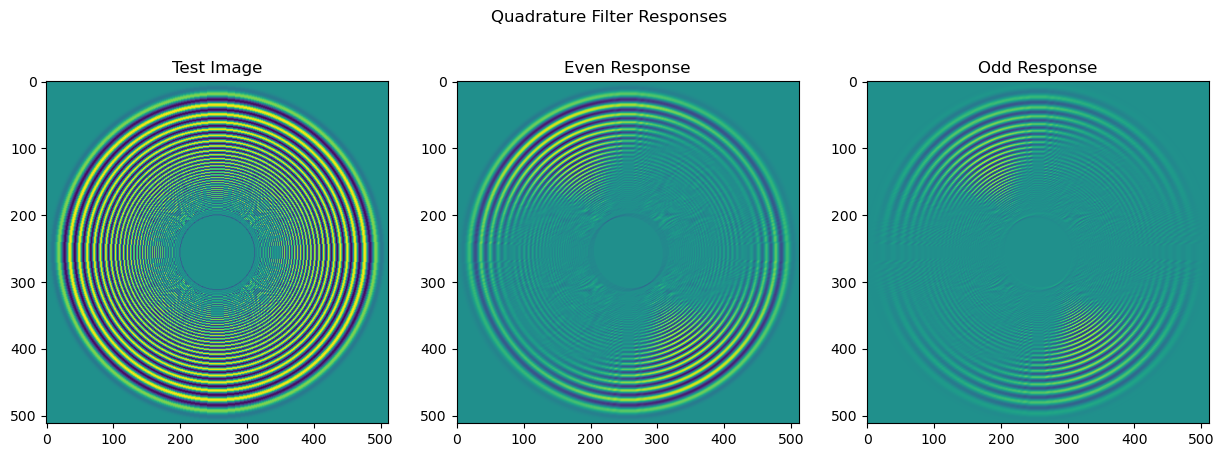

In [187]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Quadrature Filter Responses")
ax[0].imshow(test_image)
ax[0].set_title("Test Image")
ax[1].imshow(gr)
ax[1].set_title("Even Response"); 
ax[2].imshow(hr)
ax[2].set_title("Odd Response"); 

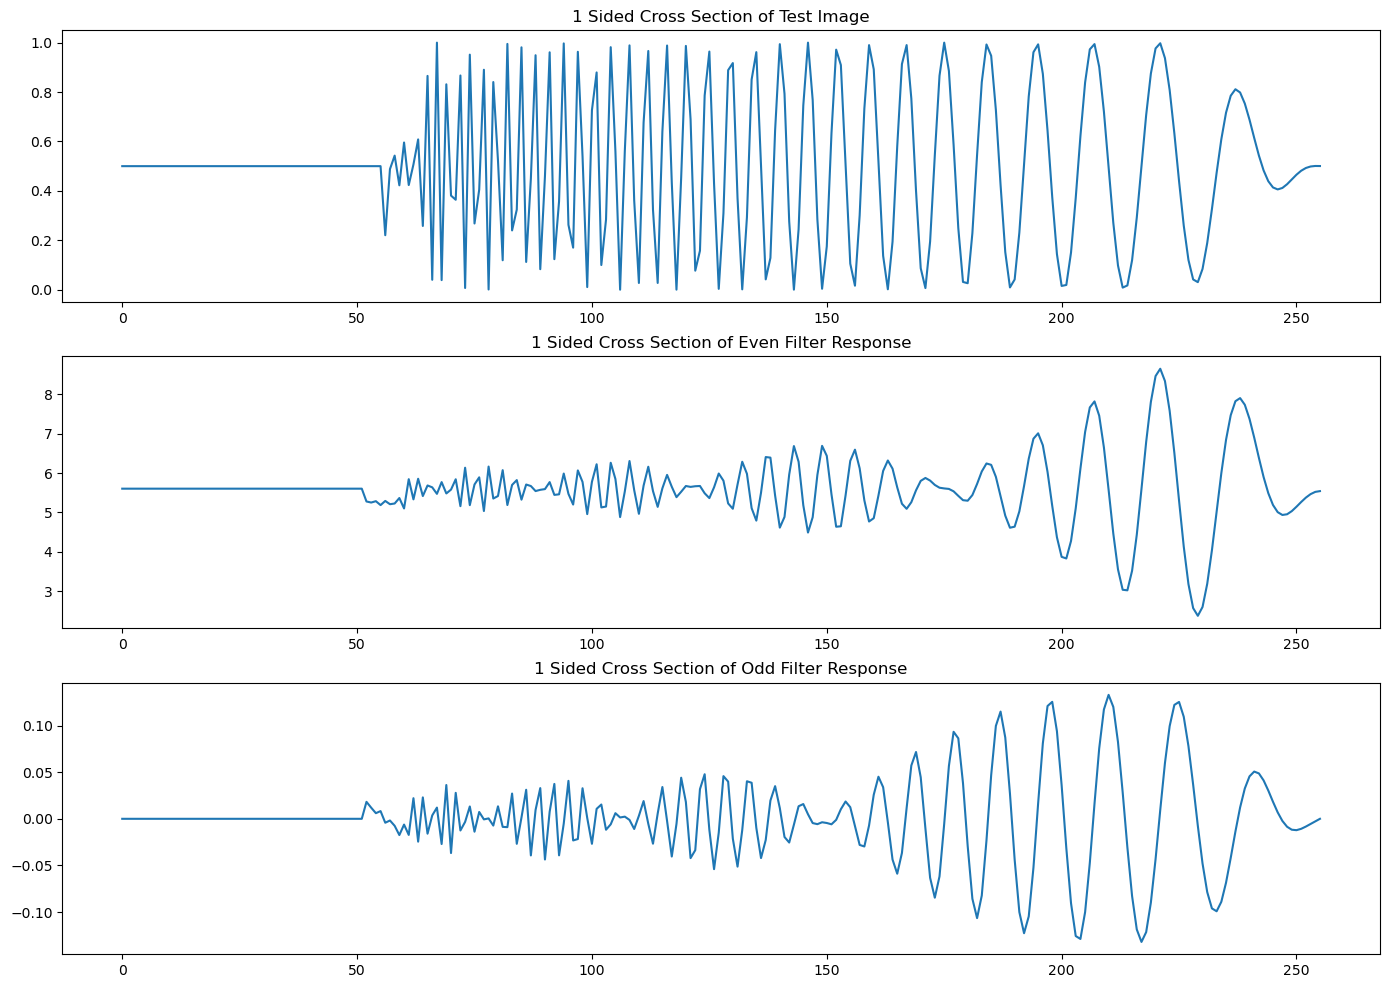

In [188]:
_, ax  = plt.subplots(3, 1, figsize=(17, 12))
ax[0].plot(test_image[256, 256:])
ax[0].set_title("1 Sided Cross Section of Test Image");
ax[1].plot(gr[256, 256:])
ax[1].set_title("1 Sided Cross Section of Even Filter Response");
ax[2].plot(hr[256, 256:])
ax[2].set_title("1 Sided Cross Section of Odd Filter Response");

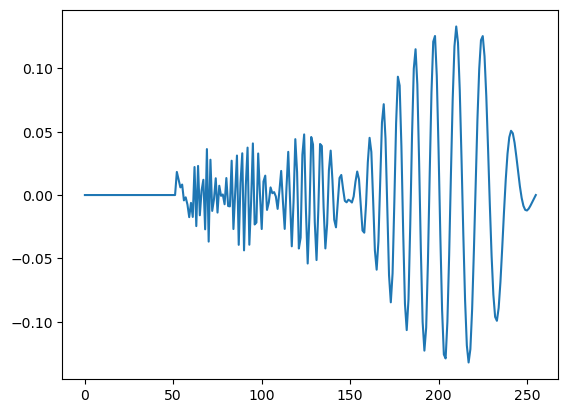

In [189]:
plt.plot(hr[256, 256:])

### Get Test Image for usage

In [190]:
from skimage.data import camera, cat, brick, horse, coffee, coins
test_image = camera()

Preprocess test image

In [191]:
# # OPTIONAL: Equalize Histogram
# test_image = cv2.equalizeHist(test_image)

# # OPTIONAL: unsharp mask
# gaus_blur = cv2.GaussianBlur(test_image, ksize=(5,5), sigmaX=5)
# test_image = cv2.addWeighted(test_image, 2.0, gaus_blur, -1.0, 0.0)

# 0-1 normalize
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

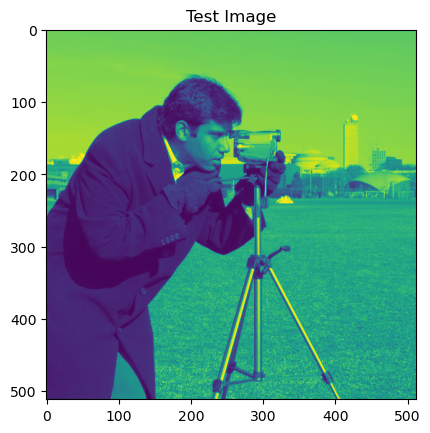

In [192]:
plt.imshow(test_image)
plt.title("Test Image");

## Get Quadrature Filter Responses

In [169]:
q_responses = []
q_mag = []
q_ang = []
for (even, odd) in zip(even_filters, odd_filters):
    even_response = cv2.filter2D(test_image, ddepth=-1, kernel=even)
    odd_response = cv2.filter2D(test_image, ddepth=-1, kernel=odd)

    q_responses.append((even_response, odd_response))

    mag, ang = cv2.cartToPolar(even_response, odd_response)
    q_mag.append(mag)
    q_ang.append(ang)

In [176]:
cv2.filter2D(test_image, ddepth=-1, kernel=even).shape

(512, 512)

In [174]:
test_image.shape, even.shape

((512, 512), (9, 9))

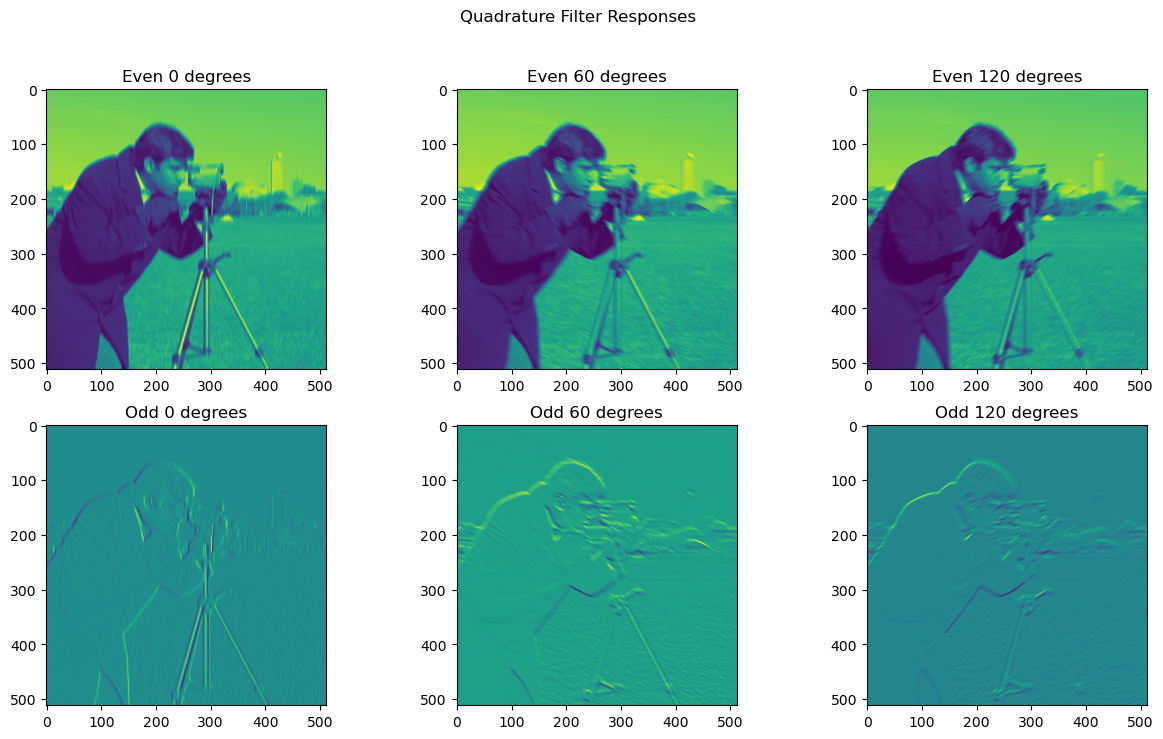

In [178]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f"Quadrature Filter Responses")
ax[0, 0].imshow(q_responses[0][0])
ax[0, 0].set_title("Even 0 degrees")
ax[0, 1].imshow(q_responses[1][0])
ax[0, 1].set_title("Even 60 degrees"); 
ax[0, 2].imshow(q_responses[2][0])
ax[0, 2].set_title("Even 120 degrees"); 
ax[1, 0].imshow(q_responses[0][1])
ax[1, 0].set_title("Odd 0 degrees")
ax[1, 1].imshow(q_responses[1][1])
ax[1, 1].set_title("Odd 60 degrees"); 
ax[1, 2].imshow(q_responses[2][1])
ax[1, 2].set_title("Odd 120 degrees"); 

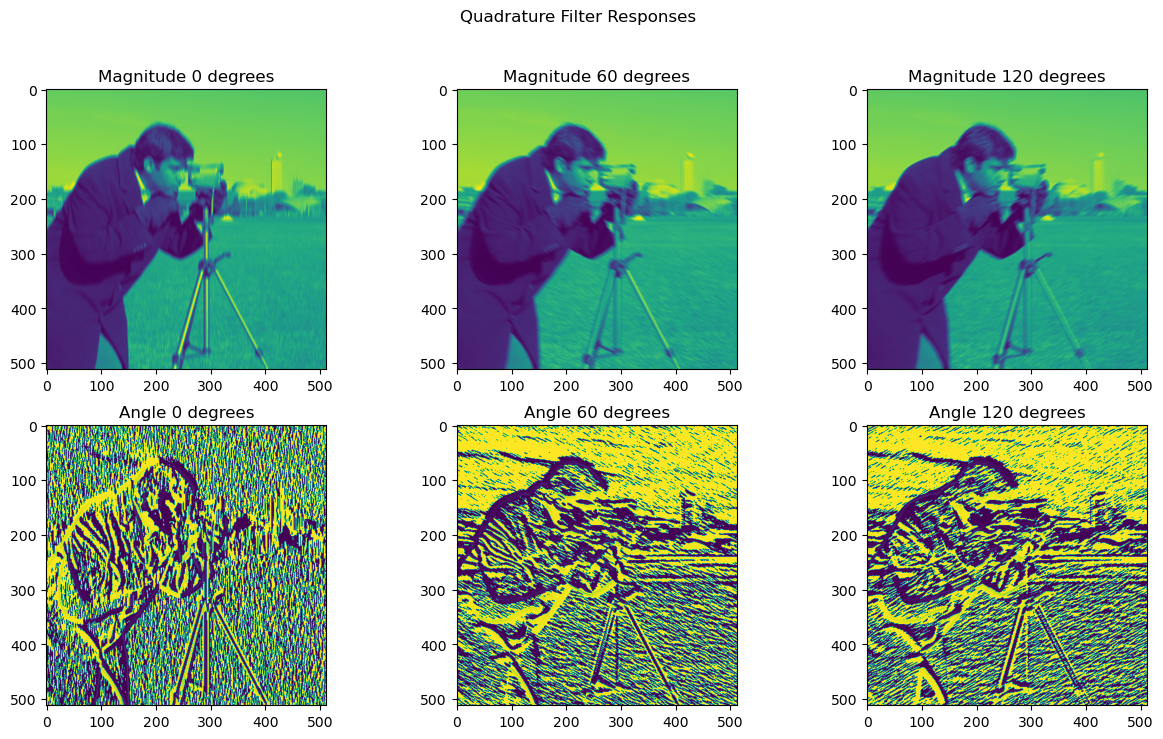

In [193]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f"Quadrature Filter Responses")
ax[0, 0].imshow(q_mag[0])
ax[0, 0].set_title("Magnitude 0 degrees")
ax[0, 1].imshow(q_mag[1])
ax[0, 1].set_title("Magnitude 60 degrees"); 
ax[0, 2].imshow(q_mag[2])
ax[0, 2].set_title("Magnitude 120 degrees"); 
ax[1, 0].imshow(q_ang[0])
ax[1, 0].set_title("Angle 0 degrees")
ax[1, 1].imshow(q_ang[1])
ax[1, 1].set_title("Angle 60 degrees"); 
ax[1, 2].imshow(q_ang[2])
ax[1, 2].set_title("Angle 120 degrees"); 

## 2D Tensor construction

construct orienting vectors $n_k$

In [194]:
a = 0.5
b = np.sqrt(3)/2

n1 = np.c_[np.array([0, 1])]
n2 = np.c_[np.array([a, b])]
n3 = np.c_[np.array([-a, b])]

In [195]:
N1 = n1 @ n1.T
N2 = n2 @ n2.T
N3 = n3 @ n3.T

I = np.eye(2)

### Get orienation tensor T

In [196]:
T = 0
for i, n in enumerate([N1, N2, N3]):
    T += np.einsum('nmk,ij->nmij', q_mag[i][:, :, None], (1.333*n - 0.333*I))

In [197]:
T.shape

(512, 512, 2, 2)

#### Get orientation vector $\hat{x}$ from orientation tensot: $T = A\hat{x}\hat{x}$, where $A$ is a positive constant

\begin{align*}
    T &= A \begin{pmatrix} x_1^2 & x_1 x_2 \\
                           x_1 x_2 & x_2^2
           \end{pmatrix}
\end{align*}

In [198]:
X = np.einsum('nmij,ij->nmj', T, I)

In [199]:
X[120, 420, :]

array([-2.63887626, 20.41027067])

### Display orienations

In [208]:
img_rows, img_cols = test_image.shape
space = 6
orientations = np.zeros_like(test_image)
for i in range(space, img_rows, space):
    for j in range(space, img_cols, space):
        # print(i,j, angle[i,j], np.cos(angle[i,j]), np.sin(angle[i,j]))
        start_point = (j, i)
        # end_point = (j + 1*np.round(mag[i,j] * np.sin(angle[i,j])).astype(int),
        #              i + 1*np.round(mag[i,j] * np.cos(angle[i,j])).astype(int))
        end_point = (j + np.round(X[i,j,1]).astype(int),
                     i + np.round(X[i,j,0]).astype(int))
        cv2.line(orientations, start_point, end_point, (255,), 1)

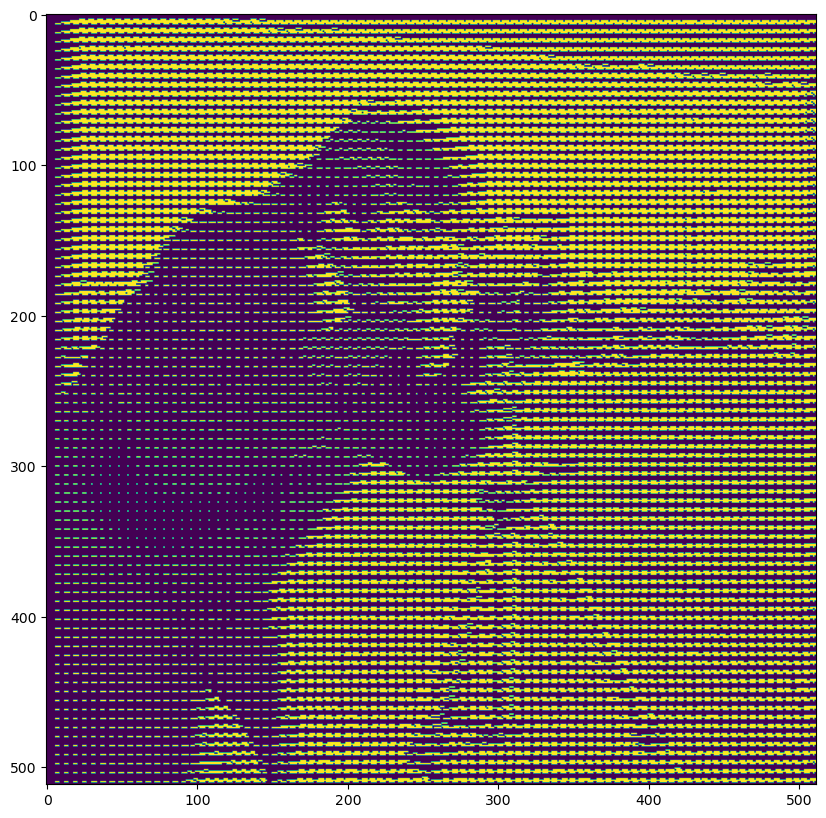

In [209]:
plt.figure(figsize=(10, 10))
plt.imshow(orientations);